In [ ]:
# importing the libraries
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.activation import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

In [ ]:
# Creating GAN class
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.0002))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.0002))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trai

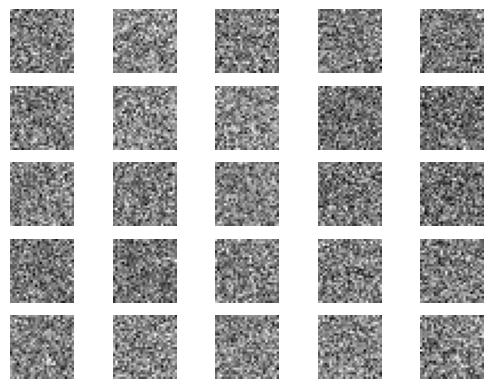

1/1 [==============================] - 0s 26ms/step
1 [Discriminator loss: 0.430106, acc.: 65.62%] [Generator loss: 0.415600]
1/1 [==============================] - 0s 21ms/step
2 [Discriminator loss: 0.415416, acc.: 59.38%] [Generator loss: 0.457189]
1/1 [==============================] - 0s 22ms/step
3 [Discriminator loss: 0.395969, acc.: 65.62%] [Generator loss: 0.587719]
1/1 [==============================] - 0s 22ms/step
4 [Discriminator loss: 0.364192, acc.: 78.12%] [Generator loss: 0.669825]
1/1 [==============================] - 0s 22ms/step
5 [Discriminator loss: 0.337740, acc.: 82.81%] [Generator loss: 0.900775]
1/1 [==============================] - 0s 24ms/step
6 [Discriminator loss: 0.316396, acc.: 87.50%] [Generator loss: 1.087678]
1/1 [==============================] - 0s 22ms/step
7 [Discriminator loss: 0.237278, acc.: 100.00%] [Generator loss: 1.239461]
1/1 [==============================] - 0s 27ms/step
8 [Discriminator loss: 0.193260, acc.: 100.00%] [Generator loss: 

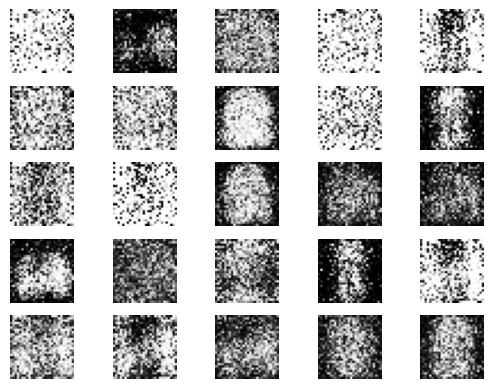

1/1 [==============================] - 0s 37ms/step
201 [Discriminator loss: 0.241908, acc.: 92.19%] [Generator loss: 3.820348]
1/1 [==============================] - 0s 32ms/step
202 [Discriminator loss: 0.430983, acc.: 81.25%] [Generator loss: 2.923361]
1/1 [==============================] - 0s 40ms/step
203 [Discriminator loss: 0.207383, acc.: 93.75%] [Generator loss: 3.212032]
1/1 [==============================] - 0s 46ms/step
204 [Discriminator loss: 0.282242, acc.: 79.69%] [Generator loss: 3.095351]
1/1 [==============================] - 0s 43ms/step
205 [Discriminator loss: 0.283776, acc.: 84.38%] [Generator loss: 3.846760]
1/1 [==============================] - 0s 32ms/step
206 [Discriminator loss: 0.653154, acc.: 64.06%] [Generator loss: 2.865292]
1/1 [==============================] - 0s 34ms/step
207 [Discriminator loss: 0.164659, acc.: 93.75%] [Generator loss: 3.411656]
1/1 [==============================] - 0s 35ms/step
208 [Discriminator loss: 0.375992, acc.: 84.38%] [Ge

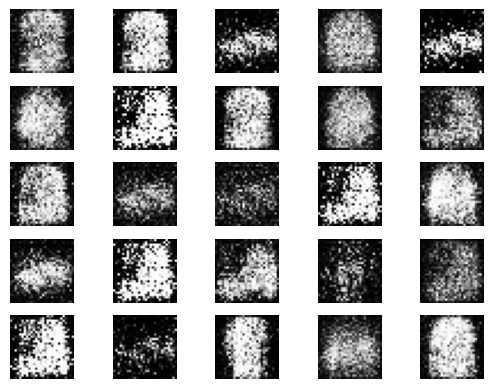

1/1 [==============================] - 0s 34ms/step
401 [Discriminator loss: 0.441780, acc.: 79.69%] [Generator loss: 2.114248]
1/1 [==============================] - 0s 29ms/step
402 [Discriminator loss: 0.662099, acc.: 60.94%] [Generator loss: 1.853710]
1/1 [==============================] - 0s 26ms/step
403 [Discriminator loss: 0.561571, acc.: 75.00%] [Generator loss: 1.890768]
1/1 [==============================] - 0s 26ms/step
404 [Discriminator loss: 0.471221, acc.: 75.00%] [Generator loss: 1.958570]
1/1 [==============================] - 0s 27ms/step
405 [Discriminator loss: 0.688055, acc.: 56.25%] [Generator loss: 1.886293]
1/1 [==============================] - 0s 36ms/step
406 [Discriminator loss: 0.468197, acc.: 79.69%] [Generator loss: 2.055432]
1/1 [==============================] - 0s 32ms/step
407 [Discriminator loss: 0.691828, acc.: 64.06%] [Generator loss: 1.593736]
1/1 [==============================] - 0s 30ms/step
408 [Discriminator loss: 0.583287, acc.: 71.88%] [Ge

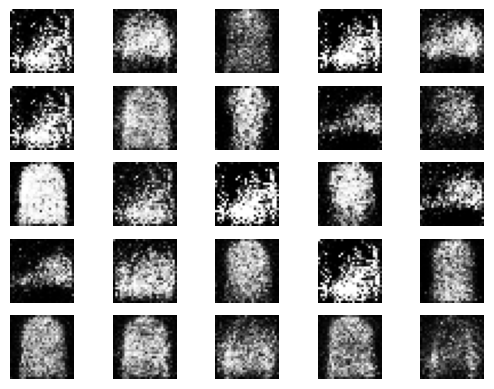

1/1 [==============================] - 0s 27ms/step
601 [Discriminator loss: 0.565964, acc.: 65.62%] [Generator loss: 1.182924]
1/1 [==============================] - 0s 23ms/step
602 [Discriminator loss: 0.637210, acc.: 67.19%] [Generator loss: 1.091274]
1/1 [==============================] - 0s 22ms/step
603 [Discriminator loss: 0.669561, acc.: 62.50%] [Generator loss: 1.012918]
1/1 [==============================] - 0s 24ms/step
604 [Discriminator loss: 0.678616, acc.: 65.62%] [Generator loss: 1.113291]
1/1 [==============================] - 0s 22ms/step
605 [Discriminator loss: 0.638054, acc.: 59.38%] [Generator loss: 1.096336]
1/1 [==============================] - 0s 21ms/step
606 [Discriminator loss: 0.586150, acc.: 70.31%] [Generator loss: 1.140570]
1/1 [==============================] - 0s 30ms/step
607 [Discriminator loss: 0.608946, acc.: 65.62%] [Generator loss: 1.117227]
1/1 [==============================] - 0s 22ms/step
608 [Discriminator loss: 0.532919, acc.: 73.44%] [Ge

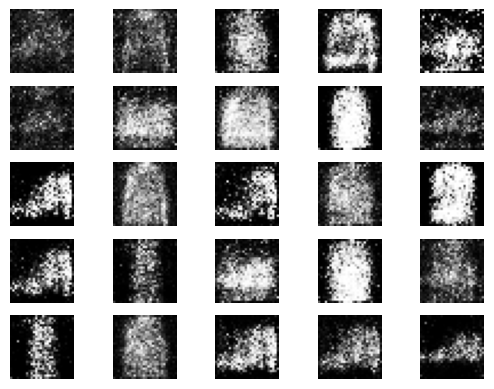

1/1 [==============================] - 0s 41ms/step
801 [Discriminator loss: 0.543767, acc.: 78.12%] [Generator loss: 1.194466]
1/1 [==============================] - 0s 52ms/step
802 [Discriminator loss: 0.661260, acc.: 64.06%] [Generator loss: 1.028848]
1/1 [==============================] - 0s 27ms/step
803 [Discriminator loss: 0.771609, acc.: 54.69%] [Generator loss: 1.004929]
1/1 [==============================] - 0s 34ms/step
804 [Discriminator loss: 0.674466, acc.: 60.94%] [Generator loss: 0.913260]
1/1 [==============================] - 0s 40ms/step
805 [Discriminator loss: 0.603628, acc.: 65.62%] [Generator loss: 1.026187]
1/1 [==============================] - 0s 42ms/step
806 [Discriminator loss: 0.609880, acc.: 65.62%] [Generator loss: 1.048387]
1/1 [==============================] - 0s 35ms/step
807 [Discriminator loss: 0.630747, acc.: 70.31%] [Generator loss: 0.983431]
1/1 [==============================] - 0s 25ms/step
808 [Discriminator loss: 0.672050, acc.: 64.06%] [Ge

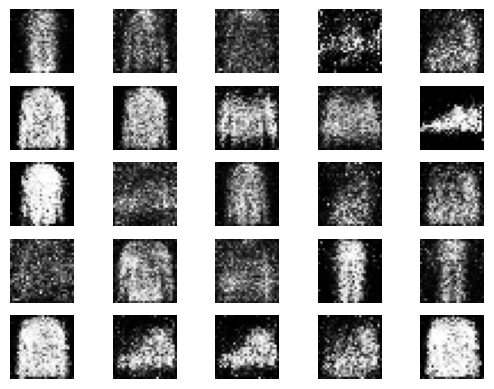

1/1 [==============================] - 0s 32ms/step
1001 [Discriminator loss: 0.693633, acc.: 54.69%] [Generator loss: 0.864789]
1/1 [==============================] - 0s 22ms/step
1002 [Discriminator loss: 0.639551, acc.: 68.75%] [Generator loss: 0.900583]
1/1 [==============================] - 0s 21ms/step
1003 [Discriminator loss: 0.597841, acc.: 65.62%] [Generator loss: 0.865918]
1/1 [==============================] - 0s 23ms/step
1004 [Discriminator loss: 0.699200, acc.: 53.12%] [Generator loss: 0.926707]
1/1 [==============================] - 0s 22ms/step
1005 [Discriminator loss: 0.716589, acc.: 56.25%] [Generator loss: 0.806106]
1/1 [==============================] - 0s 21ms/step
1006 [Discriminator loss: 0.548917, acc.: 71.88%] [Generator loss: 0.933706]
1/1 [==============================] - 0s 21ms/step
1007 [Discriminator loss: 0.659492, acc.: 60.94%] [Generator loss: 0.852676]
1/1 [==============================] - 0s 23ms/step
1008 [Discriminator loss: 0.587242, acc.: 65.

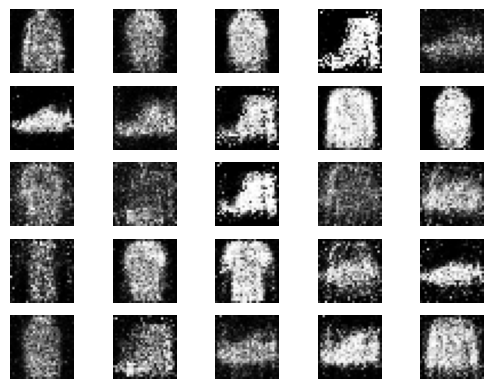

1/1 [==============================] - 0s 46ms/step
1201 [Discriminator loss: 0.599477, acc.: 64.06%] [Generator loss: 0.826871]
1/1 [==============================] - 0s 42ms/step
1202 [Discriminator loss: 0.633466, acc.: 64.06%] [Generator loss: 0.833633]
1/1 [==============================] - 0s 48ms/step
1203 [Discriminator loss: 0.688873, acc.: 46.88%] [Generator loss: 0.890100]
1/1 [==============================] - 0s 35ms/step
1204 [Discriminator loss: 0.593581, acc.: 78.12%] [Generator loss: 0.846843]
1/1 [==============================] - 0s 57ms/step
1205 [Discriminator loss: 0.624799, acc.: 59.38%] [Generator loss: 0.927126]
1/1 [==============================] - 0s 60ms/step
1206 [Discriminator loss: 0.607639, acc.: 60.94%] [Generator loss: 0.842789]
1/1 [==============================] - 0s 68ms/step
1207 [Discriminator loss: 0.565477, acc.: 70.31%] [Generator loss: 0.819278]
1/1 [==============================] - 0s 40ms/step
1208 [Discriminator loss: 0.665861, acc.: 59.

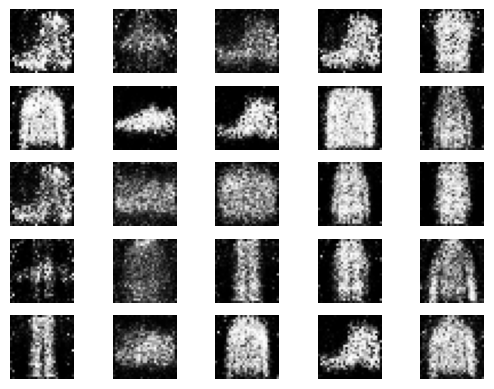

1/1 [==============================] - 0s 31ms/step
1401 [Discriminator loss: 0.645397, acc.: 65.62%] [Generator loss: 0.867242]
1/1 [==============================] - 0s 26ms/step
1402 [Discriminator loss: 0.675757, acc.: 62.50%] [Generator loss: 0.859155]
1/1 [==============================] - 0s 32ms/step
1403 [Discriminator loss: 0.645815, acc.: 56.25%] [Generator loss: 0.872760]
1/1 [==============================] - 0s 29ms/step
1404 [Discriminator loss: 0.633314, acc.: 59.38%] [Generator loss: 0.855899]
1/1 [==============================] - 0s 31ms/step
1405 [Discriminator loss: 0.619226, acc.: 65.62%] [Generator loss: 0.948323]
1/1 [==============================] - 0s 39ms/step
1406 [Discriminator loss: 0.621025, acc.: 62.50%] [Generator loss: 0.881080]
1/1 [==============================] - 0s 35ms/step
1407 [Discriminator loss: 0.668635, acc.: 53.12%] [Generator loss: 0.915754]
1/1 [==============================] - 0s 32ms/step
1408 [Discriminator loss: 0.661883, acc.: 60.

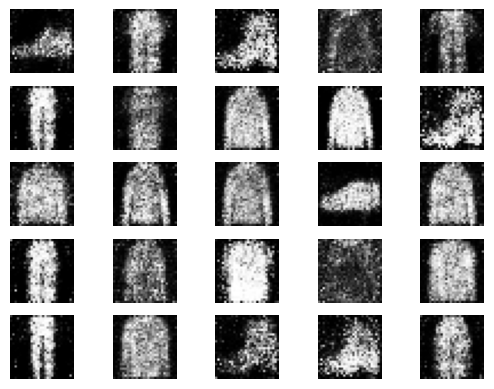

1/1 [==============================] - 0s 48ms/step
1601 [Discriminator loss: 0.613318, acc.: 65.62%] [Generator loss: 0.895324]
1/1 [==============================] - 0s 46ms/step
1602 [Discriminator loss: 0.635331, acc.: 64.06%] [Generator loss: 0.832114]
1/1 [==============================] - 0s 62ms/step
1603 [Discriminator loss: 0.592888, acc.: 64.06%] [Generator loss: 0.892396]
1/1 [==============================] - 0s 38ms/step
1604 [Discriminator loss: 0.576590, acc.: 62.50%] [Generator loss: 0.973753]
1/1 [==============================] - 0s 53ms/step
1605 [Discriminator loss: 0.584536, acc.: 68.75%] [Generator loss: 0.946000]
1/1 [==============================] - 0s 48ms/step
1606 [Discriminator loss: 0.592460, acc.: 65.62%] [Generator loss: 0.902577]
1/1 [==============================] - 0s 56ms/step
1607 [Discriminator loss: 0.577912, acc.: 70.31%] [Generator loss: 0.913358]
1/1 [==============================] - 0s 58ms/step
1608 [Discriminator loss: 0.613611, acc.: 65.

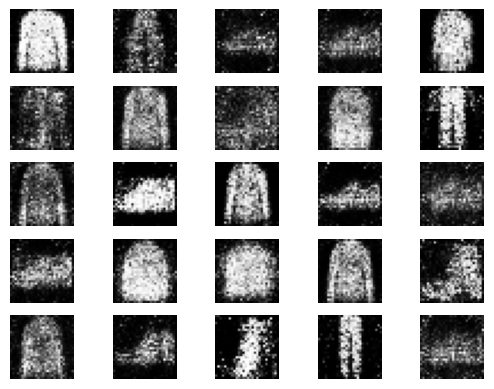

1/1 [==============================] - 0s 41ms/step
1801 [Discriminator loss: 0.658697, acc.: 62.50%] [Generator loss: 0.919654]
1/1 [==============================] - 0s 27ms/step
1802 [Discriminator loss: 0.564281, acc.: 70.31%] [Generator loss: 0.808528]
1/1 [==============================] - 0s 30ms/step
1803 [Discriminator loss: 0.610229, acc.: 65.62%] [Generator loss: 0.935629]
1/1 [==============================] - 0s 40ms/step
1804 [Discriminator loss: 0.604989, acc.: 65.62%] [Generator loss: 0.944346]
1/1 [==============================] - 0s 35ms/step
1805 [Discriminator loss: 0.566735, acc.: 78.12%] [Generator loss: 0.891896]
1/1 [==============================] - 0s 39ms/step
1806 [Discriminator loss: 0.647957, acc.: 62.50%] [Generator loss: 0.903205]
1/1 [==============================] - 0s 37ms/step
1807 [Discriminator loss: 0.613632, acc.: 64.06%] [Generator loss: 0.857276]
1/1 [==============================] - 0s 35ms/step
1808 [Discriminator loss: 0.638601, acc.: 60.

In [ ]:
gan = GAN()
gan.train(epochs=2000, batch_size=32, sample_interval=200)

1/1 [==============================] - 0s 59ms/step


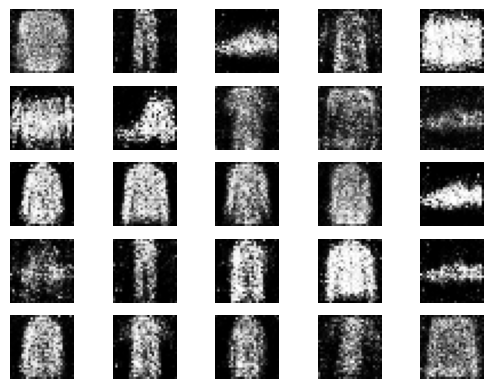

In [ ]:
gan.sample_images(1011)